# MERFISH whole mouse brain spatial transcriptomics (Xiaowei Zhuang)

A collection of in situ, spatially resolved transcriptomic profiles of individual cells in the whole mouse brain by multiplexed error-robust fluorescence in situ hybridization (MERFISH) consisting of ~9 million cells using a 1122 gene panel. We performed MERFISH imaging on 245 coronal and sagittal sections from four animal, obtained 9.3 million segmented cells that passed quality control, and integrated the MERFISH data from the four animals with the scRNA-seq data from the Allen Institute to classify cells. We applied a series of filters to select a subset of cells to be visualized on the ABC atlas. We first removed six fractured tissue slices and 9.1 million cells remained after this step. Then we aligned the spatial coordinates of the cells to the Allen-CCF-2020. For coronal slices that can be registered to the CCF, we used the CCF coordinates to define the coordinates of the center point of the midline and removed cells that substantially passed the midline in the other hemisphere (which has not been registered to the CCF). For the sagittal slices that can be registered to the CCF, we used the CCF coordinates to define the coordinates of the center point of the tissue and removed cells that substantially passed the posterior edge (which has not been registered to the CCF). For the 31 anterior and posterior coronal slices and 3 lateral sagittal slices that cannot be registered to the CCF, we manually aligned and oriented the slices. The x, y coordinates are experimentally measured coordinates after rotating and aligning the tissue slices to the CCF, and the z coordinates are estimated position of each tissue slice in the 3D Allen-CCF 2020 space along the slicing axis based on either the registration results (for slices that can be registered to CCF) or positions of the slices measured during tissue sectioning (for the slices that cannot be registered). The z position is set to zero when the estimated position becomes zero or negative. 8.4 million cells remained after this step. The cell-by-gene matrix of the 8.4 millions cells can be downloaded from the AWS bucket of this animal. We then filtered the cells by cell-classification (label transfer) confidence scores calculated during MERFISH-scRNAseq data integration. 7.0 million cells passed the confidence score threshold for cell subclass label transfer and 5.8 million cells further passed the confidence score threshold for cell cluster label transfer. These 5.8 million cells are included in the cell metadata file that can be downloaded from the the AWS bucket and are displayed on the ABC Atlas. The CCF coordinates of the 5.4 million cells that were registered to the 3D Allen-CCF can be downloaded from the CCF coordinate files in the AWB bucket. The collection spans four mouse specimens (2 coronal sets and 2 sagittal sets). Cells are mapped to the whole mouse brain taxonomy (WMB-taxonomy) and Allen Common Coordinate Framework (Allen-CCF-2020). Refer to [Zhang et al, 2023](https://doi.org/10.1101/2023.03.06.531348) for more details.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import json
import matplotlib.pyplot as plt
import requests

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
version = '20230830'
download_base = '../../abc_download_root'

use_local_cache = False
manifest_path = 'releases/%s/manifest.json' % version

if not use_local_cache :
    url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/' + manifest_path
    manifest = json.loads(requests.get(url).text)
else :
    file = os.path.join(download_base,manifest_path)
    with open(file,'rb') as f:
        manifest = json.load(f)


In [3]:
datasets = ['Zhuang-C57BL6J-1','Zhuang-C57BL6J-2','Zhuang-C57BL6J-3','Zhuang-C57BL6J-4']
example_section = {'Zhuang-C57BL6J-1':'C57BL6J-1.079',
                   'Zhuang-C57BL6J-2':'C57BL6J-2.037',
                   'Zhuang-C57BL6J-3':'C57BL6J-3.010',
                   'Zhuang-C57BL6J-4':'C57BL6J-4.002'}

metadata = {}
for d in datasets :
    metadata[d] = manifest['file_listing'][d]['metadata']

In [4]:
cache_views = False

view_directory = {} 

for d in datasets :
    
    view_directory[d] = os.path.join( download_base, 
                                     manifest['directory_listing'][d]['directories']['metadata']['relative_path'], 
                                     'views')
    if cache_views :
        os.makedirs( view_directory[d], exist_ok=True )

## Data overview

### Cell metadata

Essential cell metadata is stored as a dataframe. Each row represents one cell indexed by a *cell label*.

Each cell is associated with a *brain section label*, *donor label*, *donor genotype*, *donor sex* and *matrix_prefix* identifying which data package this cell is part of. Each cell also has a set of x, y, z coordinates generated by rotating each section so that it is upright with midline approximatedly in the middle of the frame.

Each cell is mapped to the whole mouse brain taxonomy resulting in the assignment of a *cluster alias* and *confidence scores*.

In [5]:
cell = {}

for d in datasets :
    
    rpath = metadata[d]['cell_metadata']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    cell[d] = pd.read_csv(file, dtype={"cell_label":str})
    cell[d].set_index('cell_label',inplace=True)
    
    sdf = cell[d].groupby('brain_section_label')
    
    print(d,":","Number of cells = ", len(cell[d]), ", ", "Number of sections =", len(sdf))

Zhuang-C57BL6J-1 : Number of cells =  2846908 ,  Number of sections = 147
Zhuang-C57BL6J-2 : Number of cells =  1227408 ,  Number of sections = 66
Zhuang-C57BL6J-3 : Number of cells =  1585843 ,  Number of sections = 23
Zhuang-C57BL6J-4 : Number of cells =  162578 ,  Number of sections = 3


In [6]:
cell[datasets[0]]

,brain_section_label,feature_matrix_label,donor_label,donor_genotype,donor_sex,cluster_alias,x,y,z,subclass_confidence_score,cluster_confidence_score,high_quality_transfer
cell_label,,,,,,,,,,,,
182941331246012878296807398333956011710,C57BL6J-1.089,C57BL6J-1,C57BL6J-1,wt/wt,F,704,0.682522,3.366483,7.829530,0.969933,0.718088,True
221260934538535633595532020856387724686,C57BL6J-1.089,C57BL6J-1,C57BL6J-1,wt/wt,F,5243,0.667690,3.442241,7.829530,0.850554,0.850554,True
22228792606814781533240955623030943708,C57BL6J-1.089,C57BL6J-1,C57BL6J-1,wt/wt,F,14939,0.638731,3.474328,7.829530,0.888285,0.649581,True
272043042552227961220474294517855477150,C57BL6J-1.089,C57BL6J-1,C57BL6J-1,wt/wt,F,14939,0.653425,3.433218,7.829530,0.900000,0.607080,True
110116287883089187971185374239350249328,C57BL6J-1.089,C57BL6J-1,C57BL6J-1,wt/wt,F,5254,0.623896,3.513574,7.829530,0.999978,0.689511,True
...,...,...,...,...,...,...,...,...,...,...,...,...
94310525370042131911495836073267655162,C57BL6J-1.110,C57BL6J-1,C57BL6J-1,wt/wt,F,5255,0.997247,3.823236,9.717769,0.971385,0.943456,True
298798481479578578007190103666214714353,C57BL6J-1.110,C57BL6J-1,C57BL6J-1,wt/wt,F,14939,1.043871,3.706231,9.717769,0.956377,0.905493,True
330756942354980576352210203729462562749,C57BL6J-1.110,C57BL6J-1,C57BL6J-1,wt/wt,F,5261,1.037680,3.759890,9.717769,0.811520,0.788901,True


### Cluster annotation

Read in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level and the corresponding color.

In [7]:
taxonomy_metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_pivoted']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_details = pd.read_csv(file,keep_default_na=False)
cluster_details.set_index('cluster_alias', inplace=True)

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_colors = pd.read_csv(file)
cluster_colors.set_index('cluster_alias', inplace=True)

In [8]:
cell_extended = {}

for d in datasets :
    cell_extended[d] = cell[d].join(cluster_details,on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(cluster_colors,on='cluster_alias')

In [9]:
cell_extended[datasets[0]]

,brain_section_label,feature_matrix_label,donor_label,donor_genotype,donor_sex,cluster_alias,x,y,z,subclass_confidence_score,...,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color
cell_label,,,,,,,,,,,,,,,,,,,,,
182941331246012878296807398333956011710,C57BL6J-1.089,C57BL6J-1,C57BL6J-1,wt/wt,F,704,0.682522,3.366483,7.829530,0.969933,...,GABA,06 CTX-CGE GABA,049 Lamp5 Gaba,0199 Lamp5 Gaba_1,0709 Lamp5 Gaba_1,#FF3358,#CCFF33,#FF764D,#DC00FF,#998900
221260934538535633595532020856387724686,C57BL6J-1.089,C57BL6J-1,C57BL6J-1,wt/wt,F,5243,0.667690,3.442241,7.829530,0.850554,...,,33 Vascular,331 Peri NN,1191 Peri NN_1,5304 Peri NN_1,#666666,#858881,#82992E,#2F00CC,#BB1FCC
22228792606814781533240955623030943708,C57BL6J-1.089,C57BL6J-1,C57BL6J-1,wt/wt,F,14939,0.638731,3.474328,7.829530,0.888285,...,,30 Astro-Epen,319 Astro-TE NN,1163 Astro-TE NN_3,5225 Astro-TE NN_3,#666666,#594a26,#3DCCB1,#a8afa5,#551799
272043042552227961220474294517855477150,C57BL6J-1.089,C57BL6J-1,C57BL6J-1,wt/wt,F,14939,0.653425,3.433218,7.829530,0.900000,...,,30 Astro-Epen,319 Astro-TE NN,1163 Astro-TE NN_3,5225 Astro-TE NN_3,#666666,#594a26,#3DCCB1,#a8afa5,#551799
110116287883089187971185374239350249328,C57BL6J-1.089,C57BL6J-1,C57BL6J-1,wt/wt,F,5254,0.623896,3.513574,7.829530,0.999978,...,,33 Vascular,333 Endo NN,1193 Endo NN_1,5310 Endo NN_1,#666666,#858881,#994567,#00992A,#FFB473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94310525370042131911495836073267655162,C57BL6J-1.110,C57BL6J-1,C57BL6J-1,wt/wt,F,5255,0.997247,3.823236,9.717769,0.971385,...,,33 Vascular,333 Endo NN,1193 Endo NN_1,5311 Endo NN_1,#666666,#858881,#994567,#00992A,#CC3D76
298798481479578578007190103666214714353,C57BL6J-1.110,C57BL6J-1,C57BL6J-1,wt/wt,F,14939,1.043871,3.706231,9.717769,0.956377,...,,30 Astro-Epen,319 Astro-TE NN,1163 Astro-TE NN_3,5225 Astro-TE NN_3,#666666,#594a26,#3DCCB1,#a8afa5,#551799
330756942354980576352210203729462562749,C57BL6J-1.110,C57BL6J-1,C57BL6J-1,wt/wt,F,5261,1.037680,3.759890,9.717769,0.811520,...,,33 Vascular,330 VLMC NN,1188 VLMC NN_2,5301 VLMC NN_2,#666666,#858881,#653D66,#4D5CFF,#79CC5C


For convenience, we can cache this view for later reuse.

In [10]:
if cache_views :
    
    for d in datasets :
        file = os.path.join( view_directory[d], 'cell_metadata_with_cluster_annotation.csv')
        cell_extended[d].to_csv( file )

### Gene panel

All 4 datasets shares the same 1122 gene panel selected to enable faciliate the mapping to transcriptomically defined cell types taxonomies. Each gene is uniquely identifier by an Ensembl ID. It is best practice to gene identifier to for tracking and data interchange as gene symbols are not unique and can change over time.

Each row of the gene dataframe has Ensembl gene identifier, a gene symbol and name.

In [11]:
rpath = metadata[datasets[0]]['gene']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
gene = pd.read_csv(file)
gene.set_index('gene_identifier',inplace=True)
print("Number of genes = ", len(gene))
gene.head(5)

Number of genes =  1122


,gene_symbol,name,mapped_ncbi_identifier
gene_identifier,,,
ENSMUSG00000024798,Htr7,5-hydroxytryptamine (serotonin) receptor 7,NCBIGene:15566
ENSMUSG00000042385,Gzmk,granzyme K,NCBIGene:14945
ENSMUSG00000036198,Arhgap36,Rho GTPase activating protein 36,NCBIGene:75404
ENSMUSG00000028780,Sema3c,"sema domain, immunoglobulin domain (Ig), short...",NCBIGene:20348
ENSMUSG00000015843,Rxrg,retinoid X receptor gamma,NCBIGene:20183


### Gene expression matrix

Expression values for all sections are stored in an anndata h5ad format per brain with minimal metadata. There are two h5ad files one storing the raw counts and the other log normalization of it. In this next section, we provide example code on how to open the file and connect with the rich cell level metadata discussed above.

In [12]:
expression_matrices = {}

for d in datasets :
    expression_matrices[d] = manifest['file_listing'][d]['expression_matrices']

We define a small helper function *plot sections* to visualize the cells in anatomical context colorized by: neurotransmitter identity, cell types division, class and subclass.

In [13]:
def subplot_section( ax, xx, yy, cc=None, val=None, cmap=None ) :
    
    if cmap is not None :
        ax.scatter(xx,yy,s=0.5,c=val,marker='.',cmap=cmap)
    elif cc is not None :
        ax.scatter(xx,yy,s=0.5,color=cc,marker='.')
    ax.set_ylim(11,0)
    ax.set_xlim(0,11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])


In [14]:
def plot_sections( cell_extended, example_section, cc=None, val=None, fig_width = 10, fig_height = 10, cmap=None ) :
    
    fig, ax = plt.subplots(2,2)
    fig.set_size_inches(fig_width, fig_height)
    
    for i, d in enumerate(cell_extended):
        
        pred = (cell_extended[d]['brain_section_label'] == example_section[d])
        section = cell_extended[d][pred] 
        
        if cmap is not None :
            subplot_section( ax.flat[i], section['x'], section['y'], val=section[val], cmap=cmap)
        elif cc is not None :
            subplot_section( ax.flat[i], section['x'], section['y'], section[cc])
            
        ax.flat[i].set_title(d)
        
    return fig, ax

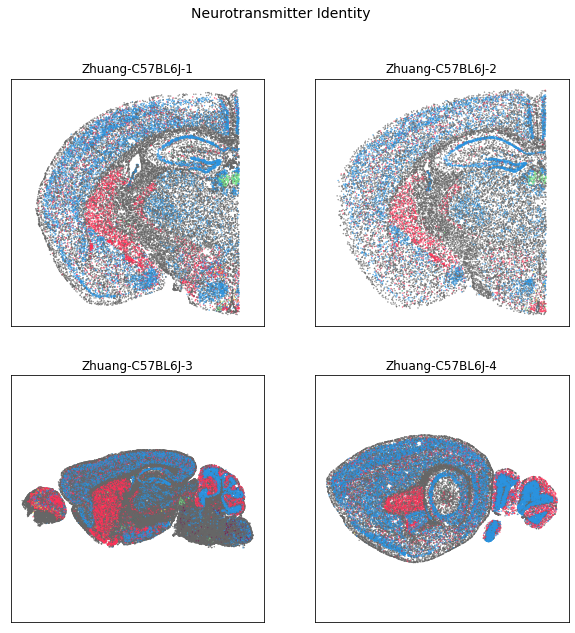

In [15]:
fig, ax = plot_sections( cell_extended, example_section, 'neurotransmitter_color' )
res = fig.suptitle('Neurotransmitter Identity', fontsize=14)

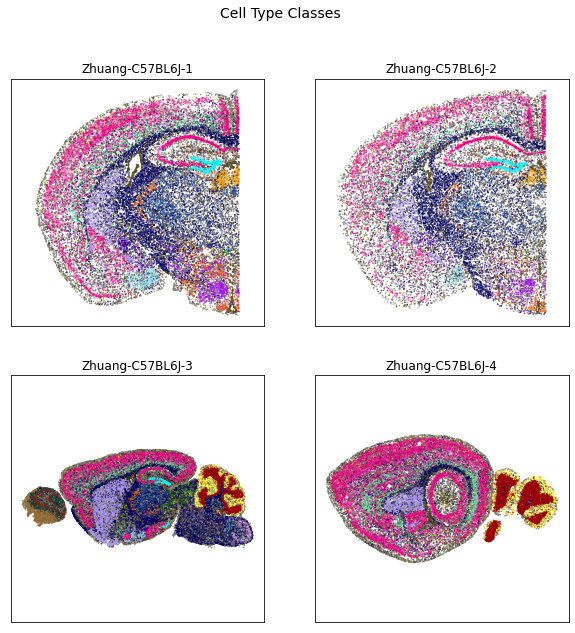

In [16]:
fig, ax = plot_sections( cell_extended, example_section, 'class_color' )
res = fig.suptitle('Cell Type Classes', fontsize=14)

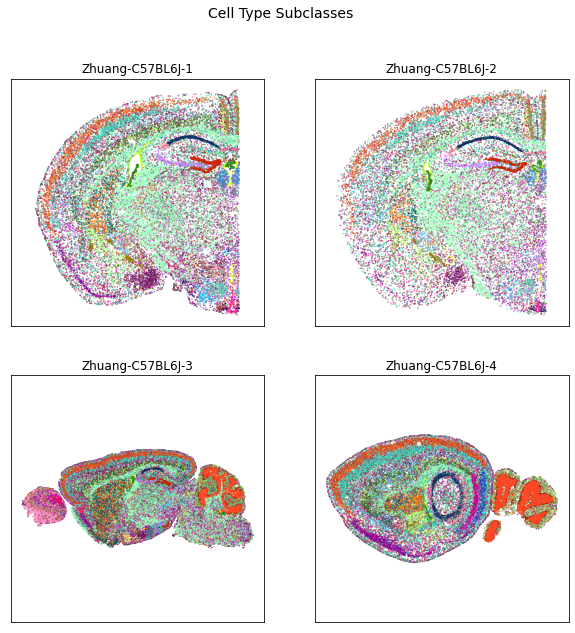

In [17]:
fig, ax = plot_sections( cell_extended, example_section, 'subclass_color' )
res = fig.suptitle('Cell Type Subclasses', fontsize=14)

## Example use case

In this section, we visualize the expression of nine canonical neurotransmitter transporter genes. To support these use cases, we will create a smaller submatrix (all cells and 9 genes) that read it into dataframe. *Note this operation takes around 2-5 minutes*.

In [18]:
gnames = ['Slc17a7','Slc17a6','Slc17a8','Slc32a1','Slc6a5','Slc6a3','Slc6a4']
pred = [x in gnames for x in gene.gene_symbol]
gene_filtered = gene[pred]
gene_filtered

,gene_symbol,name,mapped_ncbi_identifier
gene_identifier,,,
ENSMUSG00000019935,Slc17a8,solute carrier family 17 (sodium-dependent ino...,NCBIGene:216227
ENSMUSG00000021609,Slc6a3,solute carrier family 6 (neurotransmitter tran...,NCBIGene:13162
ENSMUSG00000037771,Slc32a1,solute carrier family 32 (GABA vesicular trans...,NCBIGene:22348
ENSMUSG00000039728,Slc6a5,solute carrier family 6 (neurotransmitter tran...,NCBIGene:104245
ENSMUSG00000070570,Slc17a7,solute carrier family 17 (sodium-dependent ino...,NCBIGene:72961
ENSMUSG00000020838,Slc6a4,solute carrier family 6 (neurotransmitter tran...,NCBIGene:15567
ENSMUSG00000030500,Slc17a6,solute carrier family 17 (sodium-dependent ino...,NCBIGene:140919


In [19]:
cell_expression = {}

for d in datasets :
    
    expression_matrices[d]
    rpath = expression_matrices[d][d]['log2']['files']['h5ad']['relative_path']
    file = os.path.join( download_base, rpath)
    
    adata = anndata.read_h5ad(file,backed='r')
    
    start = time.process_time()
    gdata = adata[:,gene_filtered.index].to_df()
    gdata.columns = gene_filtered.gene_symbol
    cell_expression[d] = cell_extended[d].join( gdata )
    
    print(d,"-","time taken: ", time.process_time() - start)
    
    adata.file.close()
    del adata


Zhuang-C57BL6J-1 - time taken:  25.846898455
Zhuang-C57BL6J-2 - time taken:  11.023237860000009
Zhuang-C57BL6J-3 - time taken:  12.051395306000003
Zhuang-C57BL6J-4 - time taken:  1.374322652999993


Visualize genes Slc17a7, Slc17a6, Slc32a1 for an example section from each brain

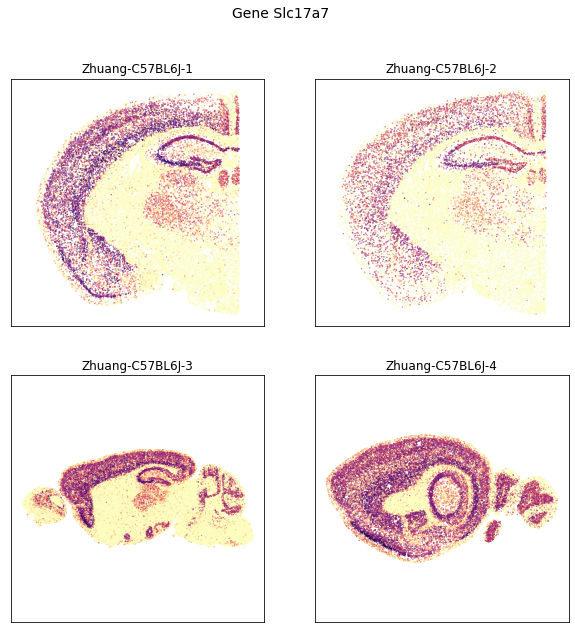

In [20]:
fig, ax = plot_sections( cell_expression, example_section, val='Slc17a7', cmap=plt.cm.magma_r)
res = fig.suptitle('Gene Slc17a7', fontsize=14)

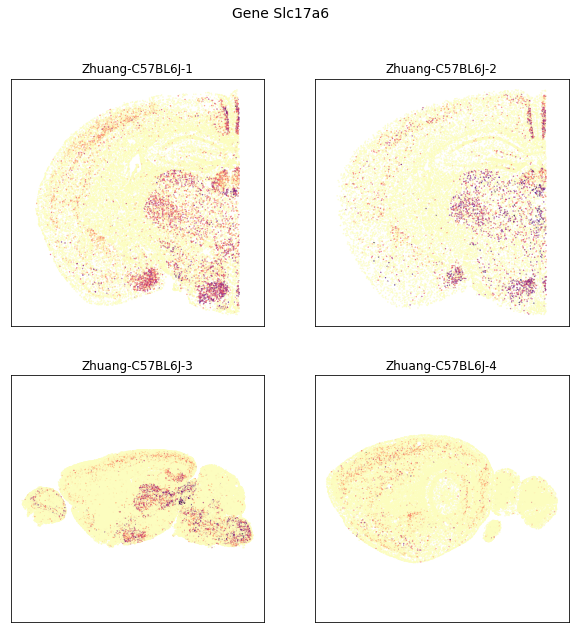

In [21]:
fig, ax = plot_sections( cell_expression, example_section, val='Slc17a6', cmap=plt.cm.magma_r)
res = fig.suptitle('Gene Slc17a6', fontsize=14)

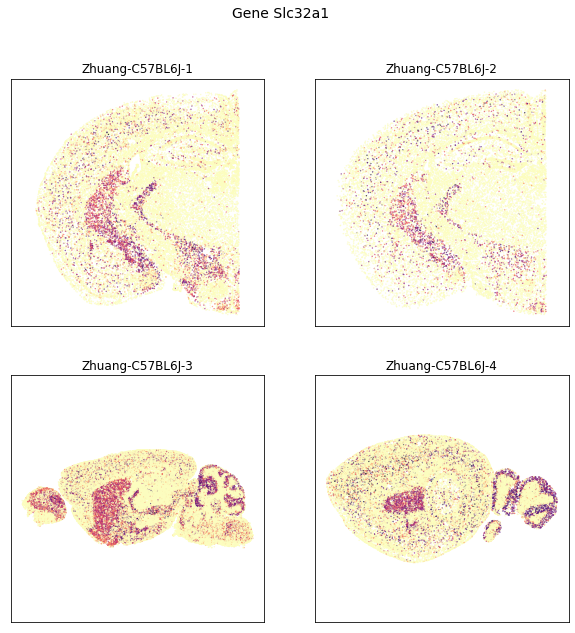

In [22]:
fig, ax = plot_sections( cell_expression, example_section, val='Slc32a1', cmap=plt.cm.magma_r)
res = fig.suptitle('Gene Slc32a1', fontsize=14)

### CCF registration and parcellation annotation

Each brain specimen has been registered to Allen CCFv3 atlas, resulting in an x, y, z coordinates and parcellation_index for each cell. 

In [23]:
ccf_coordinates = {}

for d in datasets :
    
    rpath = manifest['file_listing'][d+'-CCF']['metadata']['ccf_coordinates']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    ccf_coordinates[d] = pd.read_csv(file)
    ccf_coordinates[d].set_index('cell_label',inplace=True)
    ccf_coordinates[d].rename(columns={'x':'x_ccf','y':'y_ccf','z':'z_ccf'},inplace=True)
    
    cell_extended[d] = cell_extended[d].join(ccf_coordinates[d],how='inner')

In [24]:
ccf_coordinates[datasets[0]]

,x_ccf,y_ccf,z_ccf,parcellation_index
cell_label,,,,
182941331246012878296807398333956011710,7.902190,3.048426,0.582962,0
221260934538535633595532020856387724686,7.906513,3.145200,0.577602,0
22228792606814781533240955623030943708,7.906110,3.182761,0.553731,0
272043042552227961220474294517855477150,7.904627,3.131808,0.563525,0
110116287883089187971185374239350249328,7.907236,3.230647,0.543048,0
...,...,...,...,...
94310525370042131911495836073267655162,9.681244,4.453979,0.852027,0
298798481479578578007190103666214714353,9.676999,4.291647,0.899531,1109
330756942354980576352210203729462562749,9.678760,4.363282,0.894082,1109


Read in the pivot table from the "parcellation annotation tutorial" to associate each cell with terms at each anatomical parcellation level and the corresponding color.

In [25]:
metadata = manifest['file_listing']['Allen-CCF-2020']['metadata']
rpath = metadata['parcellation_to_parcellation_term_membership_acronym']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_annotation = pd.read_csv(file)
parcellation_annotation.set_index('parcellation_index',inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]

rpath = metadata['parcellation_to_parcellation_term_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_color = pd.read_csv(file)
parcellation_color.set_index('parcellation_index',inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

In [26]:
for d in datasets :
    cell_extended[d] = cell_extended[d].join(parcellation_annotation,on='parcellation_index')
    cell_extended[d] = cell_extended[d].join(parcellation_color,on='parcellation_index')   

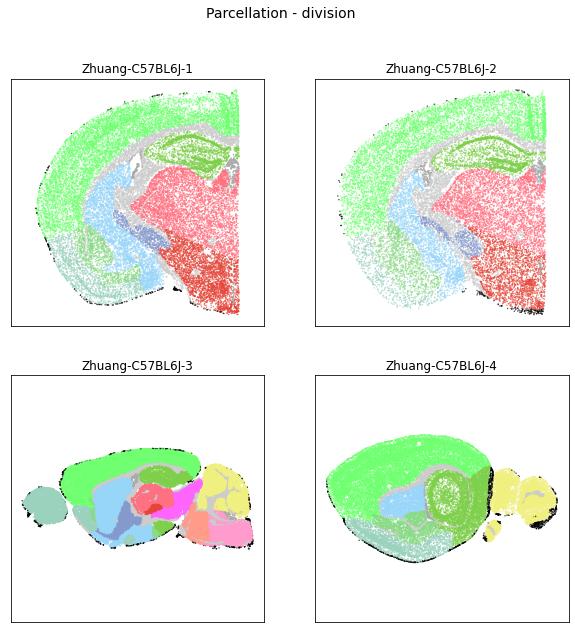

In [27]:
fig, ax = plot_sections( cell_extended, example_section, 'parcellation_division_color' )
res = fig.suptitle('Parcellation - division', fontsize=14)

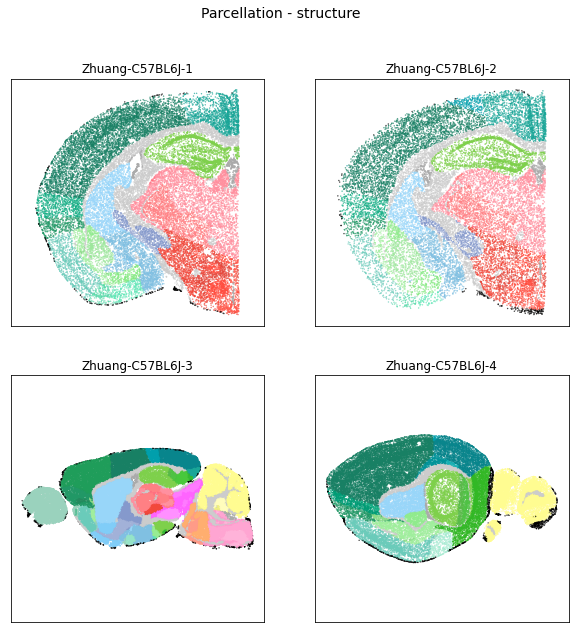

In [28]:
fig, ax = plot_sections( cell_extended, example_section, 'parcellation_structure_color' )
res = fig.suptitle('Parcellation - structure', fontsize=14)

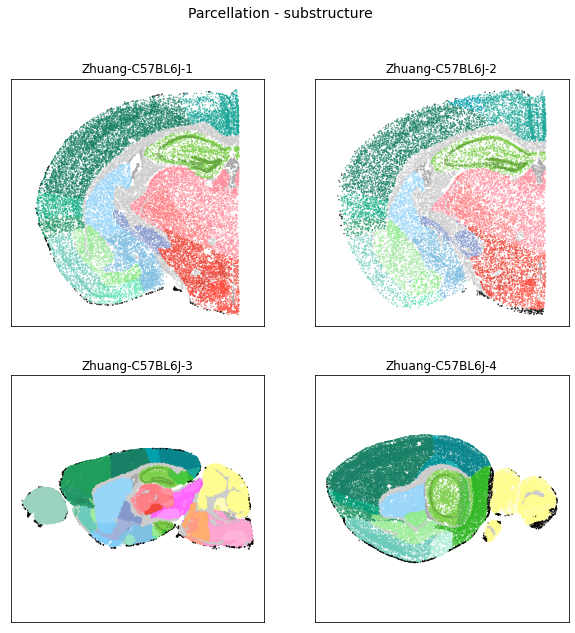

In [29]:
fig, ax = plot_sections( cell_extended, example_section, 'parcellation_substructure_color' )
res = fig.suptitle('Parcellation - substructure', fontsize=14)